#### Task 1 (5 points):

##### go to https://github.com/miaow1988/SqueezeNet_v1.2 and download the 'symbol.json' and '.params' files (there is not a 'synset.txt' file! so don't use these lines, Hint: just comment these lines).

* Install MXNet v1.5 (hint: create a new conda environmet with python 3, pip install mxnet==1.5.1) and follow the same steps of the lecture (part: *Using pre-trained models as feature extractors*). Find the flatten output layer and create a feature extractor (hint: It should be a numpy array of 1000 elements).

In [1]:
! pip install mxnet==1.5.1

In [2]:
! pip install requests matplotlib opencv-python-headless

In [3]:
from __future__ import print_function

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon

ctx = mx.cpu()

In [5]:
path='https://github.com/miaow1988/SqueezeNet_v1.2/'
[mx.test_utils.download(path+'raw/master/model-symbol.json'),
 mx.test_utils.download(path+'raw/master/model-0000.params')]

['model-symbol.json', 'model-0000.params']

In [6]:
sym, arg_params, aux_params = mx.model.load_checkpoint('model', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

In [8]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['fire9_concat_output',
 'dropout0_output',
 'conv10_conv_weight',
 'conv10_conv_bias',
 'conv10_conv_output',
 'conv10_relu_output',
 'pool10_output',
 'flatten0_output',
 'softmax_label',
 'softmax_output']

In [9]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [10]:
img = get_image('https://github.com/dmlc/web-data/blob/master/mxnet/doc/tutorials/python/predict_image/dog.jpg?raw=true')
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()
print(features)
assert features.shape == (1, 1000)

[[ 4.845196   3.4268258  7.843049   7.9837413  5.0658007 10.121918
   6.799952   5.7677264  7.273711   5.127602   7.018298   4.811454
   8.284684   8.654723   6.049178   8.718851   7.764751   7.7427015
   7.589762   6.1869006  6.810075   8.739559  11.090771  12.213647
  16.161835   3.6743853  7.5311394  4.516597   5.586503   6.4256606
   9.150993  11.08033    9.99549    7.6564336  9.058346   8.437614
  11.678422  10.139231  10.436383   9.725912  10.097718   6.6340404
   9.135065  14.396064   5.0995846  6.848199   7.687456  10.579806
   7.166281   6.6813297  8.84578   13.9824295  2.5840075  2.0861392
   4.7771173  2.387622   4.4640617  2.0931792  4.1492095  3.3739567
   2.5934505  6.3983226  2.8615527  3.679117   2.8022115  3.6225042
   6.1064415  2.7667575  3.0884964 11.78726    6.608432   6.033763
   5.073381   5.8935313  6.046323   5.0844703  5.387423   7.6845536
   6.8027067  2.9404893  8.930441   6.3438115  6.3796887  7.5792623
   8.03119    9.870219   7.6333404 12.44468    8.11980

* Download the dogs versus cats *training folder* from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data (Remember the number of images is 12500 for each class).

In [11]:
pip install python-slugify

Note: you may need to restart the kernel to use updated packages.


In [12]:
from subprocess import run
from time import time

start = time()
script = f'''
    pip install --upgrade --force-reinstall --no-deps kaggle;
    mkdir -p ~/.kaggle;
    cp ~/kaggle.json ~/.kaggle/;
    chmod 600 ~/.kaggle/kaggle.json;
    kaggle competitions download --quiet -c dogs-vs-cats-redux-kernels-edition;
    unzip -o dogs-vs-cats-redux-kernels-edition.zip;
    unzip -o train.zip;
    '''
proc = run(script,
          shell = True,
          text = True,
          capture_output = True,
          timeout = 120)
print(proc.stderr)
print(f'runtime{time()-start:.0f} sec')


runtime16 sec


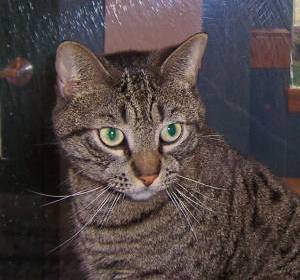

In [13]:
import os
from IPython.core.display import Image
display(Image(f'{os.getcwd()}/train/cat.1.jpg'))

In [14]:
from os.path import isfile, join
mypath = join(os.getcwd(),'train')

In [15]:
from os import listdir
from os.path import isfile, join
import os

cats_imgs = [join(mypath,f) for f in listdir(mypath) if f.startswith('cat')]
dogs_imgs = [join(mypath,f) for f in listdir(mypath) if f.startswith('dog')]

In [16]:
print("cats: {} and dogs: {}".format(len(cats_imgs),len(dogs_imgs)))

cats: 12500 and dogs: 12500


In [17]:
def get_image(url, show=False):
    if url.startswith('http'):
        # download and show the image
        fname = mx.test_utils.download(url)
    else:
        fname = url
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))


In [18]:
def get_features(img):
    fe_mod.forward(Batch([mx.nd.array(img)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    return features

* Extract the array of features for different number of images (N: 10, 100, 500, 1000, also 5000 and 12500) and for each value train your favorite binary classifier (only one!!!) using GridSearch to optimize some hyperparameters. Consider to use https://notebooks.csc.fi if you have computational limitations. 

* Report the accuracy for each value of N and the computational time during the training step.

In [19]:
Nmax = 10
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

Best cross-validation accuracy: 1.00
Best set score: 1.00
Best parameters:  {'Preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1)), 'svc__C': 0.001, 'svc__gamma': 1}

---Runtime: 0 seconds ---


In [21]:
Nmax = 100
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [22]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

Best cross-validation accuracy: 0.96
Best set score: 0.94
Best parameters:  {'Preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1)), 'svc__C': 1, 'svc__gamma': 0.01}

---Runtime: 3 seconds ---


In [23]:
Nmax = 500
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [24]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

In [25]:
Nmax = 1000
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [26]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

In [27]:
Nmax = 5000
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [28]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

In [29]:
Nmax = 12500
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [30]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

#### Task 2 (5 points):

Repeat all previous steps using MobileNet V2 (https://github.com/KeyKy/mobilenet-mxnet). How the two networks compare in terms of accuracy and running time?

In [31]:
path='https://github.com/KeyKy/mobilenet-mxnet'
[mx.test_utils.download(path+'/blob/master/mobilenet_v2-symbol.json'),
 mx.test_utils.download(path+'/blob/master/mobilenet_v2-0000.params')]

['mobilenet_v2-symbol.json', 'mobilenet_v2-0000.params']

In [32]:
import os 
from subprocess import run
script = f'ls -l {os.getcwd()} | grep mobilenet_v2'
print(run(script, shell = True, text = True, capture_output = True).stdout)

-rw-r--r--. 1 jovyan root  14178924 Nov 15 11:12 mobilenet_v2-0000.params
-rw-r--r--. 1 jovyan root    108565 Nov 15 12:34 mobilenet_v2-symbol.json



In [33]:
# ! wget https://github.com/KeyKy/mobilenet-mxnet/raw/master/mobilenet_v2-0000.params
# ! wget https://github.com/KeyKy/mobilenet-mxnet/raw/master/mobilenet_v2-symbol.json

In [34]:
sym, arg_params, aux_params = mx.model.load_checkpoint("mobilenet_v2", 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [35]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['conv6_4_bn_moving_var',
 'conv6_4_bn_output',
 'relu6_4_output',
 'pool6_output',
 'fc7_weight',
 'fc7_bias',
 'fc7_output',
 'fc7_flatten_output',
 'prob_label',
 'prob_output']

In [38]:
fe_sym = all_layers['fc7_flatten_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [39]:
Nmax = 10
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

Best cross-validation accuracy: 0.65
Best set score: 0.80
Best parameters:  {'Preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1)), 'svc__C': 0.001, 'svc__gamma': 0.01}

---Runtime: 0 seconds ---


In [41]:
Nmax = 100
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [42]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

Best cross-validation accuracy: 0.59
Best set score: 0.70
Best parameters:  {'Preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1)), 'svc__C': 1, 'svc__gamma': 0.01}

---Runtime: 4 seconds ---


In [43]:
Nmax = 500
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [44]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

Best cross-validation accuracy: 0.60
Best set score: 0.80
Best parameters:  {'Preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1)), 'svc__C': 100, 'svc__gamma': 0.01}

---Runtime: 80 seconds ---


In [ ]:
Nmax = 1000
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [ ]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

In [ ]:
Nmax = 5000
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [ ]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

In [ ]:
Nmax = 12500
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [ ]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

pipe = Pipeline([('Preprocessing', MinMaxScaler()), ('svc', SVC())])

start_time = time()
param_grid = {'Preprocessing': [MinMaxScaler()], 'svc__C': [0.001, 0.1, 1, 100], 'svc__gamma': [0.01, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_cvd, Y_cvd)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
print(f'\n---Runtime: {time() - start_time:.0f} seconds ---')

SqueezeNet is better in terms of both accuracy and running time.

#### Task 3 (5 points):

Using the best network. Train a machine learning model able to predic COVID-19 from chest X-Ray images. Use the data from https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset. 

Present and discuss your best model.

Type Markdown and LaTeX:  𝛼2

In [57]:
! pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset?select=Chest_xray_Corona_Metadata.csv')

     |████████████████████████████████| 97 kB 3.2 MB/s eta 0:00:011


  0%|          | 1.00M/1.19G [00:00<03:46, 5.62MB/s]

100%|██████████| 1.19G/1.19G [00:20<00:00, 62.5MB/s]


In [58]:
from os import listdir
from os.path import isfile, join
import os

mypath = join(os.getcwd(),'train')

In [59]:
sym, arg_params, aux_params = mx.model.load_checkpoint('model', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [61]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['fire9_concat_output',
 'dropout0_output',
 'conv10_conv_weight',
 'conv10_conv_bias',
 'conv10_conv_output',
 'conv10_relu_output',
 'pool10_output',
 'flatten0_output',
 'softmax_label',
 'softmax_output']

In [62]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [66]:
from os import listdir
from os.path import isfile, join
import os

imgs = [join(mypath,f) for f in listdir(mypath)]

In [71]:
print("Number of Images: {}".format(len(imgs)))

Number of Images: 25000
